In [1]:
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

In [2]:
def weighted_smoothing(predictions, size):
    predictions_new = predictions.copy()
    group_start = [0]
    group_start = np.hstack((group_start, np.where(np.diff(predictions) != 0)[0] + 1))
    for i in range(len(group_start) - 3):
        if group_start[i + 2] - group_start[i + 1] < size:
            if predictions_new[group_start[i + 2]] == predictions_new[group_start[i]] and \
                    predictions_new[group_start[i]:group_start[i + 1]].shape[0] >= size and \
                    predictions_new[group_start[i + 2]:group_start[i + 3]].shape[0] >= size:
                predictions_new[group_start[i]:group_start[i + 2]] = predictions_new[group_start[i]]
    for i in range(len(group_start) - 3):
        if group_start[i + 1] - group_start[i] < size:
            predictions_new[group_start[i]:group_start[i + 1]] = predictions_new[group_start[i] - 1]
    return predictions_new


def compute_matrix(labels, n):
    tm = [[0] * n for _ in range(n)]
    for (i, j) in zip(labels, labels[1:]):
        tm[i][j] += 1

    index_not = list(set(np.arange(n)) - set(np.unique(labels)))
    tm_df = pd.DataFrame(tm)
    tm_df = tm_df.drop(index=index_not, columns=index_not)
    tm_array = np.array(tm_df)
    tm_norm = tm_array / tm_array.sum(axis=1)
    return tm_array, tm_df, tm_norm


class directed_graph:

    def __init__(self, soft_assignments, new_predictions):
        self.soft_assignments = soft_assignments
        self.new_predictions = new_predictions
        self.node_sizes = []
        self.transition_matrix_norm = []

    def compute_dynamics(self, indices):
        # initialize some array
        tm_count_all = []
        tm_prob_all = []
        # for the files you've listed, obtain the transition matrix, append into a list
        for idx in indices:
            tm_array, tm_df, tm_norm = compute_matrix(self.new_predictions[idx],
                                                      len(np.unique(self.soft_assignments)))
            ## raw counts
            tm_count_all.append(tm_array)
            ## normalized probability
            tm_prob_all.append(tm_norm)
        # nan-neglected mean across all files
        tm_count_mean = np.nanmean(tm_count_all, axis=0)
        tm_prob_mean = np.nanmean(tm_prob_all, axis=0)
        # rescale probability after losing the self-transition
        diag = [tm_count_mean[i][i] for i in range(len(tm_count_mean))]
        diag_p = np.array(diag) / np.array(diag).max()
        # keep diag to provide information about relative behavioral duration
        # scale it by 50, works well, and save it as a global variable
        self.node_sizes = [50 * i for i in diag_p]
        ## transition matrix from 2d array into numpy matrix for networkx
        transition_matrix = np.matrix(tm_prob_mean)
        # replace diagonal with 0
        np.fill_diagonal(transition_matrix, 0)
        self.transition_matrix_norm = transition_matrix / transition_matrix.sum(axis=1)
        nan_indices = np.isnan(self.transition_matrix_norm)
        self.transition_matrix_norm[nan_indices] = 0
        return self.transition_matrix_norm


    def plot(self):
        fig = plt.figure()
        # particular networkx graph
        graph = nx.from_numpy_array(self.transition_matrix_norm, create_using=nx.MultiDiGraph())
        # set node position with seed 0 for reproducibility
        node_position = nx.layout.spring_layout(graph, seed=0)
        # edge colors is equivalent to the weight
        edge_colors = [graph[u][v][0].get('weight') for u, v in graph.edges()]
        # node is dependent on the self transitions, which is defined in compute dynamics above, use blue colormap
        nodes = nx.draw_networkx_nodes(graph, node_position, node_size=self.node_sizes,
                                       node_color='blue')
        # edges are drawn as arrows with blue colormap, size 8 with width 1.5
        edges = nx.draw_networkx_edges(graph, node_position, node_size=self.node_sizes, arrowstyle='->',
                                       arrowsize=8, edge_color=edge_colors, edge_cmap=plt.cm.Blues, width=1.5)
        # label position is 0.005 to the right of the node
        label_pos = [node_position[i] + 0.005 for i in range(len(node_position))]
        # draw labels with font size 10
        nx.draw_networkx_labels(graph, label_pos, font_size=10)
        # generate colorbar from the edge colors
        pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
        pc.set_array(edge_colors)
        plt.colorbar(pc)
        ax = plt.gca()
        ax.set_axis_off()
        return fig

    def main(self, indices):
        # runs both
        self.compute_dynamics(indices)
        self.plot()


In [3]:
sampled_features, sampled_embeddings = joblib.load('../data/prelim/Feb-20-2023_embeddings.sav')
_, assignments, _, soft_assignments = joblib.load('../data/prelim/Feb-20-2023_clusters.sav')
folders, folder, filenames, new_data, new_predictions = joblib.load('../data/prelim/seal_depleted_ko_predictions.sav')

In [4]:
behavior_names = ['pause', 'sniff_1', 'sniff_2', 'groom', 'rear',
                  'sniff_3', 'groom/rear', 'orientL', 'loco_Lfore', 'orientR_Rfore',
                  'loco_Rfore', 'orientR_Lfore']
behav_order = ['pause','sniff_1','sniff_2','sniff_3', 'rear',
               'groom/rear','groom','orientL', 'orientR_Lfore', 'orientR_Rfore',
               'loco_Lfore', 'loco_Rfore']
behavior_order_idx = [behavior_names.index(behav_order[i]) for i in range(len(behav_order))]

/var/folders/gp/nsk60k_n2cz7kk79_pv33d8r0000gn/T/ipykernel_68911/1329100984.py:90: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(pc)
/var/folders/gp/nsk60k_n2cz7kk79_pv33d8r0000gn/T/ipykernel_68911/1329100984.py:90: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(pc)


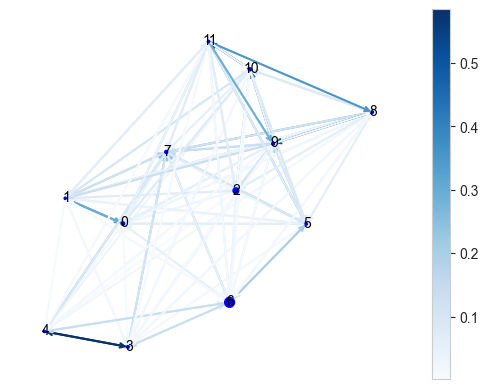

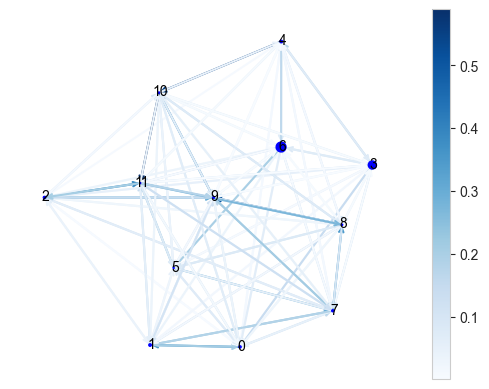

In [5]:
tmat_norm = dict()
graph = dict()
# initialize network
network = directed_graph(soft_assignments, new_predictions)
for i, f in enumerate(filenames):
    tmat_norm_unordered = network.compute_dynamics([i])
    tmat_norm[i] = tmat_norm_unordered[:, behavior_order_idx][behavior_order_idx]
    graph[i] = network.plot()


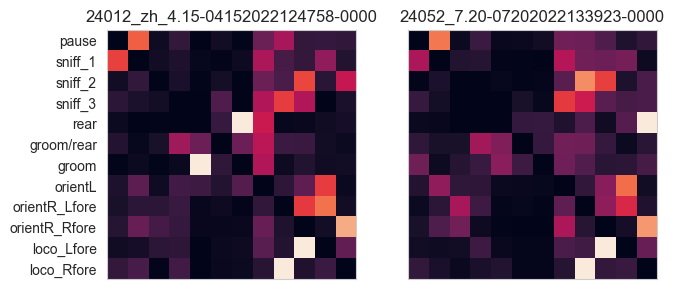

In [6]:
# transition matrix sorted
rows = 3
cols = 3
count = 0
fig, ax = plt.subplots(rows, cols, figsize=(11, 11), sharex=True, sharey=True)
for row in range(rows):
    for col in range(cols):
        try:
            ax[row, col].set_title(filenames[count].rpartition('DLC_')[0].rpartition('\\')[2]
            )
            ax[row, col].imshow(tmat_norm[count], vmin=0, vmax=0.5)
            ax[row, col].set_xticks(np.arange(tmat_norm[count].shape[0]))
            if row == rows-1:
                ax[row, col].set_xticklabels(behav_order, rotation=90)
            ax[row, col].set_yticks(np.arange(tmat_norm[count].shape[0]))
            if col == 0:
                ax[row, col].set_yticklabels(behav_order)
            count += 1
            ax[row, col].grid(False)
        except:
            fig.delaxes(ax[row, col])
            pass
plt.show()
# fig.savefig('../figures/behavioral_transitions.png', dpi=600)